In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

perc_axes = 0.07409181787428054


# 2. Set up grid

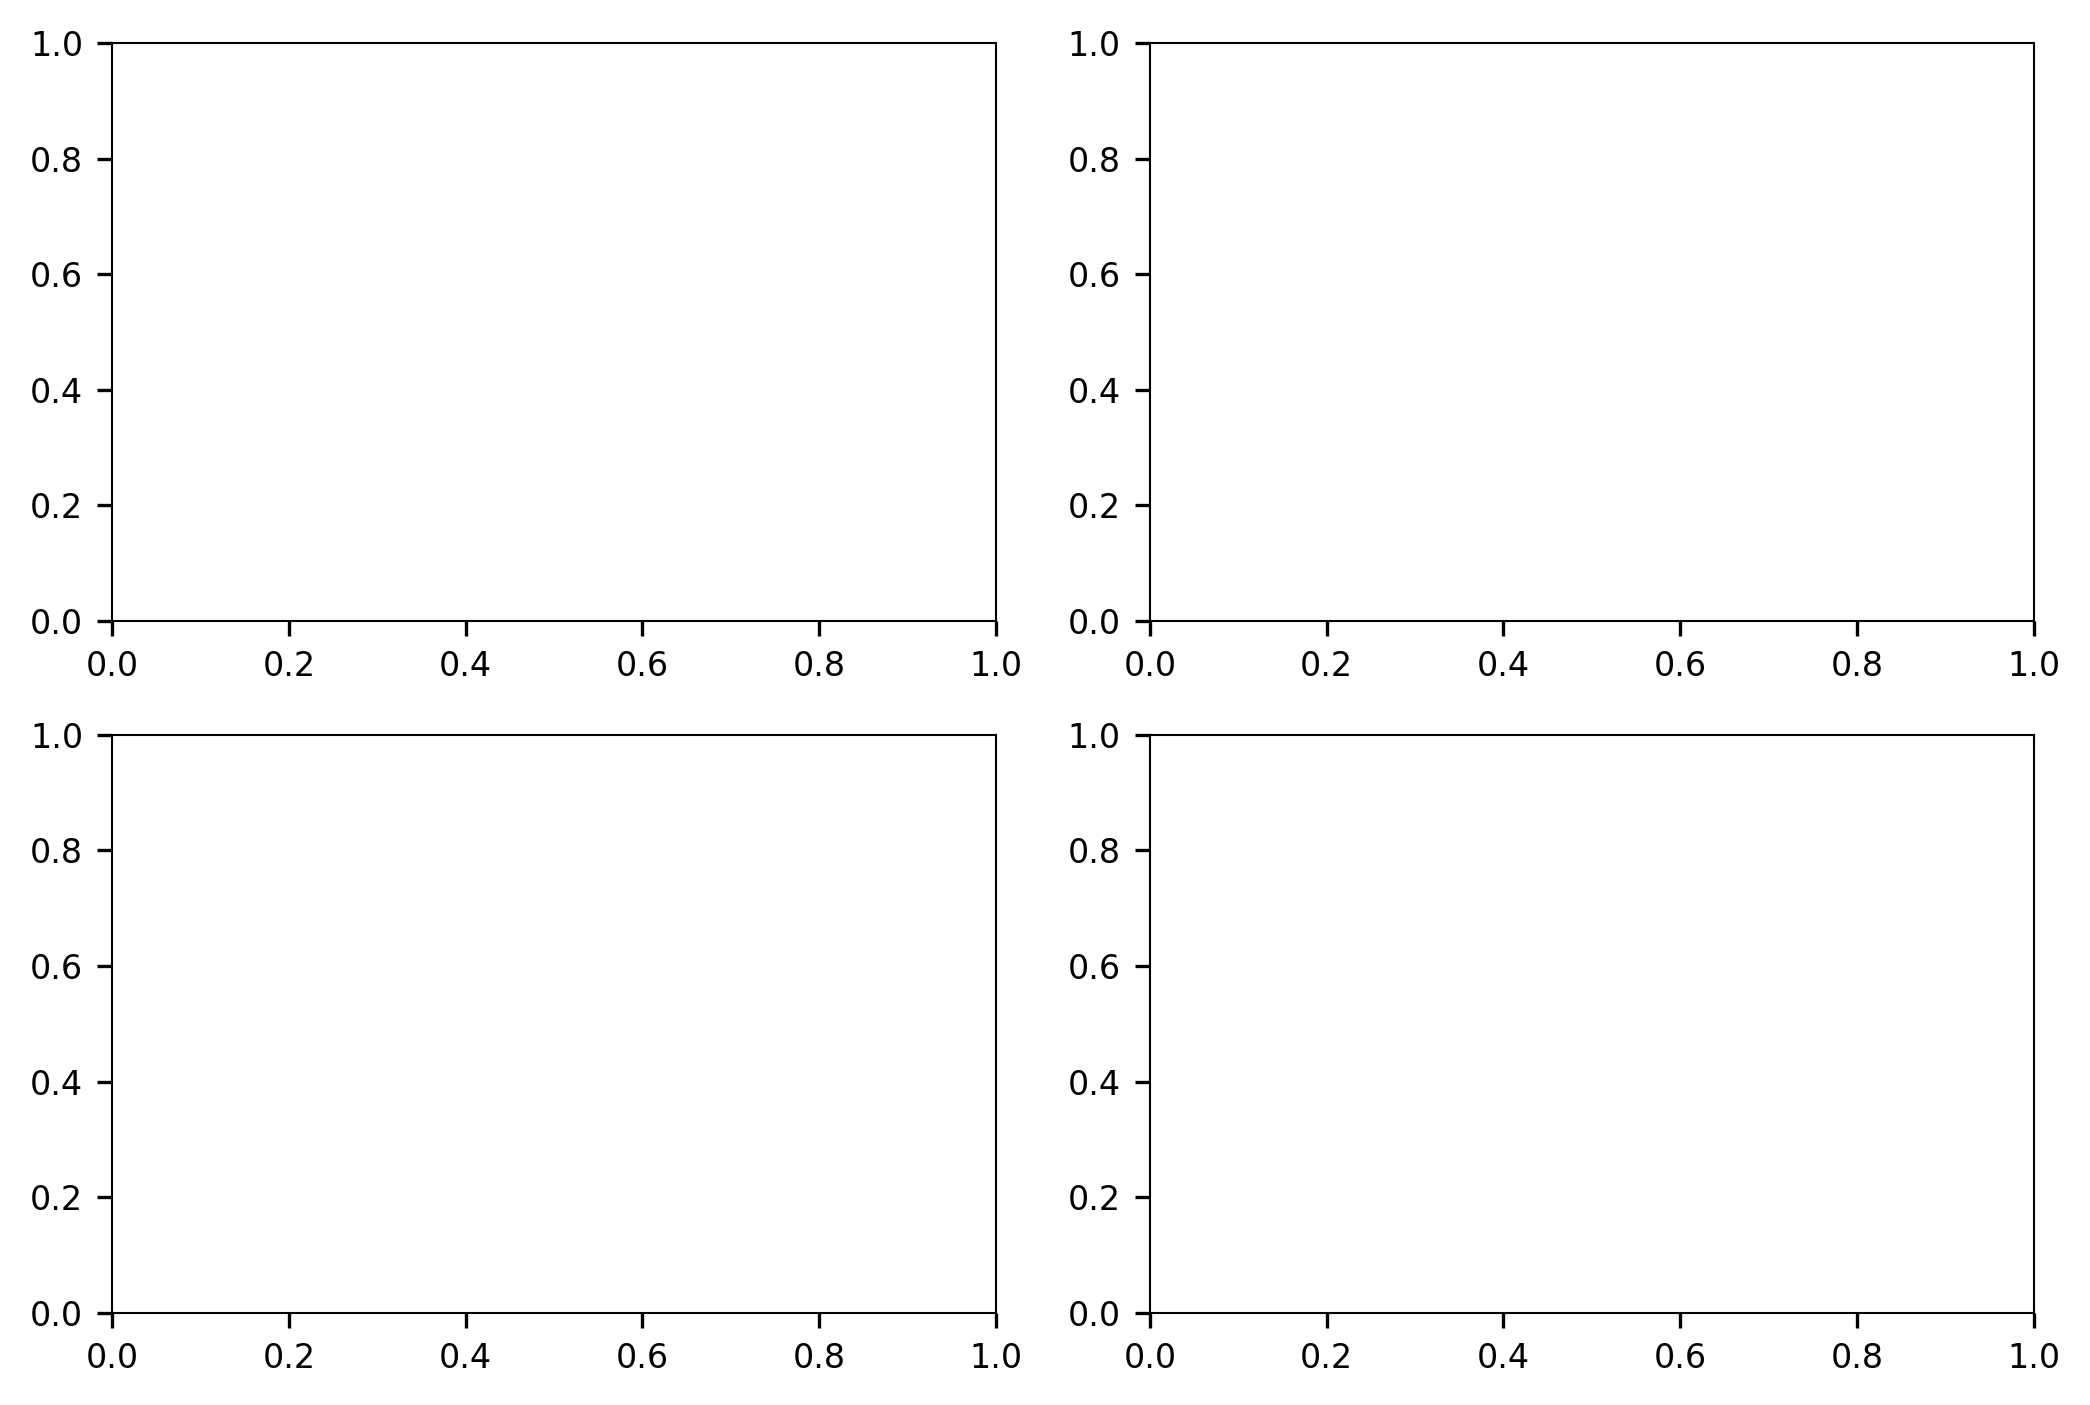

In [3]:
width = 174 / 25.4
height = 116 / 25.4
fig3 = plt.figure(constrained_layout=True, figsize=(width, height))
gs = fig3.add_gridspec(2, 2)
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax4 = fig3.add_subplot(gs[1, 0])
f3_ax5 = fig3.add_subplot(gs[1, 1])

# B. DMSO replicate correlation

In [4]:
if 'raw_data' not in locals():
    raw_data = pd.HDFStore('../raw_data/2017.07.24_Radicicol_exp.h5')

In [5]:
filename = '../raw_data/20200814_edward_unformatted.summary'
growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)

samples = [
    'WT',
    'K298M',
    'Vector',
    'E381K',
    'W289H',
    'T293D',
    'G291L',
    'T443K',
    'F512A',
    'F512P'
]
wells_per_sample = 6

well_dict = {}
for idx, sample in enumerate(samples):
    
    # Get row number and convert to letter
    row_idx = idx % 8
    row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1
    
    # Determine if it's cols 1-6 or 7-12
    if idx / 8 >= 1.0:
        cols = np.arange(7, 13)
    else:
        cols = np.arange(1, 7)
    
    # Create dictionary where key=sample, value=wells
    well_dict[sample] = [row_char + str(col_idx) for col_idx in cols]
    
    
# Add sample_id and condition columns
growth_rates['Variant'] = np.nan
growth_rates['condition'] = np.nan
for sample, wells in well_dict.items():
    dmso_wells = wells[:int(wells_per_sample / 2)]
    rad_wells = wells[int(wells_per_sample / 2):]
    growth_rates.loc[wells, 'Variant'] = sample
    growth_rates.loc[dmso_wells, 'condition'] = 'DMSO'
    growth_rates.loc[rad_wells, 'condition'] = 'Radicicol'
    
growth_rates.dropna(inplace=True)

# Separate out controls
control_grs = growth_rates.loc[((growth_rates['Variant'] == 'WT')
 | (growth_rates['Variant'] == 'K298M')
 |  (growth_rates['Variant'] == 'Vector')
 | (growth_rates['Variant'] == 'E381K'))]

# Make palette
cartoon_blue = (20/225., 199/255., 222/255.)
cartoon_red = (226/255., 106/255., 106/255.)
src_palette = sns.color_palette([cartoon_blue, cartoon_red])

# A. Radicicol replicate correlation

In [6]:
variant_scores = pd.read_csv('../utils/syn_scores_shared.csv', index_col=0, header=[0,1,2])
rep1 = -1 * variant_scores.loc[:, ('Radicicol', 'Rad1', 'score')].values
rep2 = -1 * variant_scores.loc[:, ('Radicicol', 'Rad2', 'score')].values

# Combine replicates into a dataframe to drop variants with NaNs
rep_df = pd.DataFrame([rep1, rep2]).T
rep_df.dropna(inplace=True)

# Plot on grid
ax = f3_ax1
ax.scatter(rep_df[0], rep_df[1], c=src_palette[-1], alpha=0.2)

# Calculate correlation coefficient using scipy and plot on graph
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(rep_df[0], rep_df[1])

# Get limits
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
score_range = max_val - min_val
ax.set_xlim((min_val, max_val))
ax.set_ylim((min_val, max_val))

# Assign text position
ax.text(min_val + perc_axes * score_range, max_val - perc_axes * score_range, '$r$ = %0.2f' % r_value)

# Set axes labels
ax.set_xlabel('Rep1 radicicol activity score')
ax.set_ylabel('Rep2 radicicol activity score')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(13.333333333333332, 0.5, 'Rep2 radicicol activity score')

In [7]:
from scipy.stats import pearsonr, spearmanr 

rad1 = variant_scores[('Radicicol', 'Rad1', 'score')].values
rad2 = variant_scores[('Radicicol', 'Rad2', 'score')].values
rad_nanmask = (~np.isnan(rad1) & ~np.isnan(rad2))
rad_r, rad_r_pval = pearsonr(rad1[rad_nanmask], rad2[rad_nanmask])
rad_rho, rad_rho_pval = spearmanr(rad1[rad_nanmask], rad2[rad_nanmask])

dmso1 = variant_scores[('Zero', 'Zero1' ,'score')].values
dmso2 = variant_scores[('Zero', 'Zero2' ,'score')].values
dmso_nanmask = (~np.isnan(dmso1) & ~np.isnan(dmso2))
dmso_r, dmso_r_pval = pearsonr(dmso1[dmso_nanmask], dmso2[dmso_nanmask])
dmso_rho, dmso_rho_pval = spearmanr(dmso1[dmso_nanmask], dmso2[dmso_nanmask])

print('DMSO r: {:.4f}, DMSO rho: {:.4f}'.format(dmso_r, dmso_rho))
print('Rad r: {:.4f}, Rad rho : {:.4f}'.format(rad_r, rad_rho) )

DMSO r: 0.8933, DMSO rho: 0.9184
Rad r: 0.8630, Rad rho : 0.8572


In [8]:
# Plot activity scores
point_muts = pd.read_csv('../utils/point_muts.csv', index_col=0, header=[0,1])
resids = pd.read_csv('../utils/residuals.csv', index_col=0)

point_muts.rename(index=dict(zip(point_muts.index.values, resids.index.values)), inplace=True)


# Remove variants not in library
samples = [
    'WT',
    'K298M',
    'Empty',
    'E381K',
    'W289H',
    'T293D',
    'G291L',
    'T443K',
    'F512A',
    'F512P',
    'E381S',
    'W285N',
    'E283V',
    'P302Y',
    'S333R'
    
]
samples_in_lib = samples.copy()
samples_in_lib[0] = '_wt'
samples_in_lib.remove('E381K')
samples_in_lib.remove('Empty')

# Pull out radicicol and DMSO activity scores for variants in scan and tested
point_muts_in_lib = point_muts.loc[samples_in_lib]
samples_in_lib_rad = point_muts_in_lib.loc[:, ('Radicicol', 'score')]
samples_in_lib_dmso = point_muts_in_lib.loc[:, ('Zero', 'score')]

In [9]:
filename = '../raw_data/20201031_cal_curve.summary'
growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)

wells_per_sample = 6

well_dict = {}
for idx, sample in enumerate(samples):
    
    # Get row number and convert to letter
    row_idx = idx % 8
    row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1
    
    # Determine if it's cols 1-6 or 7-12
    if idx / 8 >= 1.0:
        cols = np.arange(7, 13)
    else:
        cols = np.arange(1, 7)
    
    # Create dictionary where key=sample, value=wells
    well_dict[sample] = [row_char + str(col_idx) for col_idx in cols]
    
# Add sample_id and condition columns
growth_rates['sample_id'] = np.nan
growth_rates['condition'] = np.nan
for sample, wells in well_dict.items():
    dmso_wells = wells[:int(wells_per_sample / 2)]
    rad_wells = wells[int(wells_per_sample / 2):]
    growth_rates.loc[wells, 'sample_id'] = sample
    growth_rates.loc[dmso_wells, 'condition'] = 'DMSO'
    growth_rates.loc[rad_wells, 'condition'] = 'Radicicol'
    
growth_rates.dropna(inplace=True)

In [10]:
# Get average growth rates and stdv for all variants in scan and tested
dmso_rates = []
rad_rates = []

dmso_std = []
rad_std = []
for sample in samples_in_lib:
    if sample is '_wt':
        sample = 'WT'
    df_slice = growth_rates[growth_rates['sample_id'] == sample]
    dmso_slice = df_slice[df_slice['condition'] == 'DMSO']
    rad_slice = df_slice[df_slice['condition'] == 'Radicicol']

    dmso_rates.append(dmso_slice['Rate'].mean())
    rad_rates.append(rad_slice['Rate'].mean())
    
    dmso_std.append(dmso_slice['Rate'].std())
    rad_std.append(rad_slice['Rate'].std())
    
dmso_rates = np.array(dmso_rates)
rad_rates = np.array(rad_rates)
dmso_std = np.array(dmso_std)
rad_std = np.array(rad_std)

In [11]:
ax = f3_ax4

ax.scatter(samples_in_lib_dmso, dmso_rates, color='#b3b3b3', label='Basal')
ax.scatter(samples_in_lib_rad, rad_rates, c=src_palette[1], label='-Hsp90')

ax.errorbar(samples_in_lib_dmso, dmso_rates, yerr=dmso_std, color='#b3b3b3', fmt='none')
ax.errorbar(samples_in_lib_rad, rad_rates, yerr=rad_std, c=src_palette[1], fmt='none')

slope_d, intercept_d, r_value_d, p_value_d, std_err_d = scipy.stats.linregress(samples_in_lib_dmso, dmso_rates)
f_d = np.poly1d([slope_d, intercept_d])
ax.plot(samples_in_lib_dmso, f_d(samples_in_lib_dmso), color='#b3b3b3')

slope_r, intercept_r, r_value_r, p_value_r, std_err_r = scipy.stats.linregress(samples_in_lib_rad, rad_rates)
f_r = np.poly1d([slope_r, intercept_r])
ax.plot(samples_in_lib_dmso, f_r(samples_in_lib_dmso), c=src_palette[1])

ax.set_ylim([0, 0.0031])
ax.legend()
ax.set_ylabel('Growth rate (OD600/min)')
ax.set_xlabel('Activity score')
print(r_value_d, r_value_d)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-0.9067357917619615 -0.9067357917619615


In [12]:
import pickle
diffsel_var = pickle.load(open('../utils/diffsel_var_dna.pkl', 'rb'))

# B. Synonymous and nonsynonymous distributions

## DMSO distributions

synon mean: 0.11626839482365992 
 synon sd: 0.48175488865231625 
 synon mean - 2sd: -0.8472413824809726 
 synon mean + 2sd: 1.0797781721282924


Text(1051.1679790026246, 0.5, 'Density')

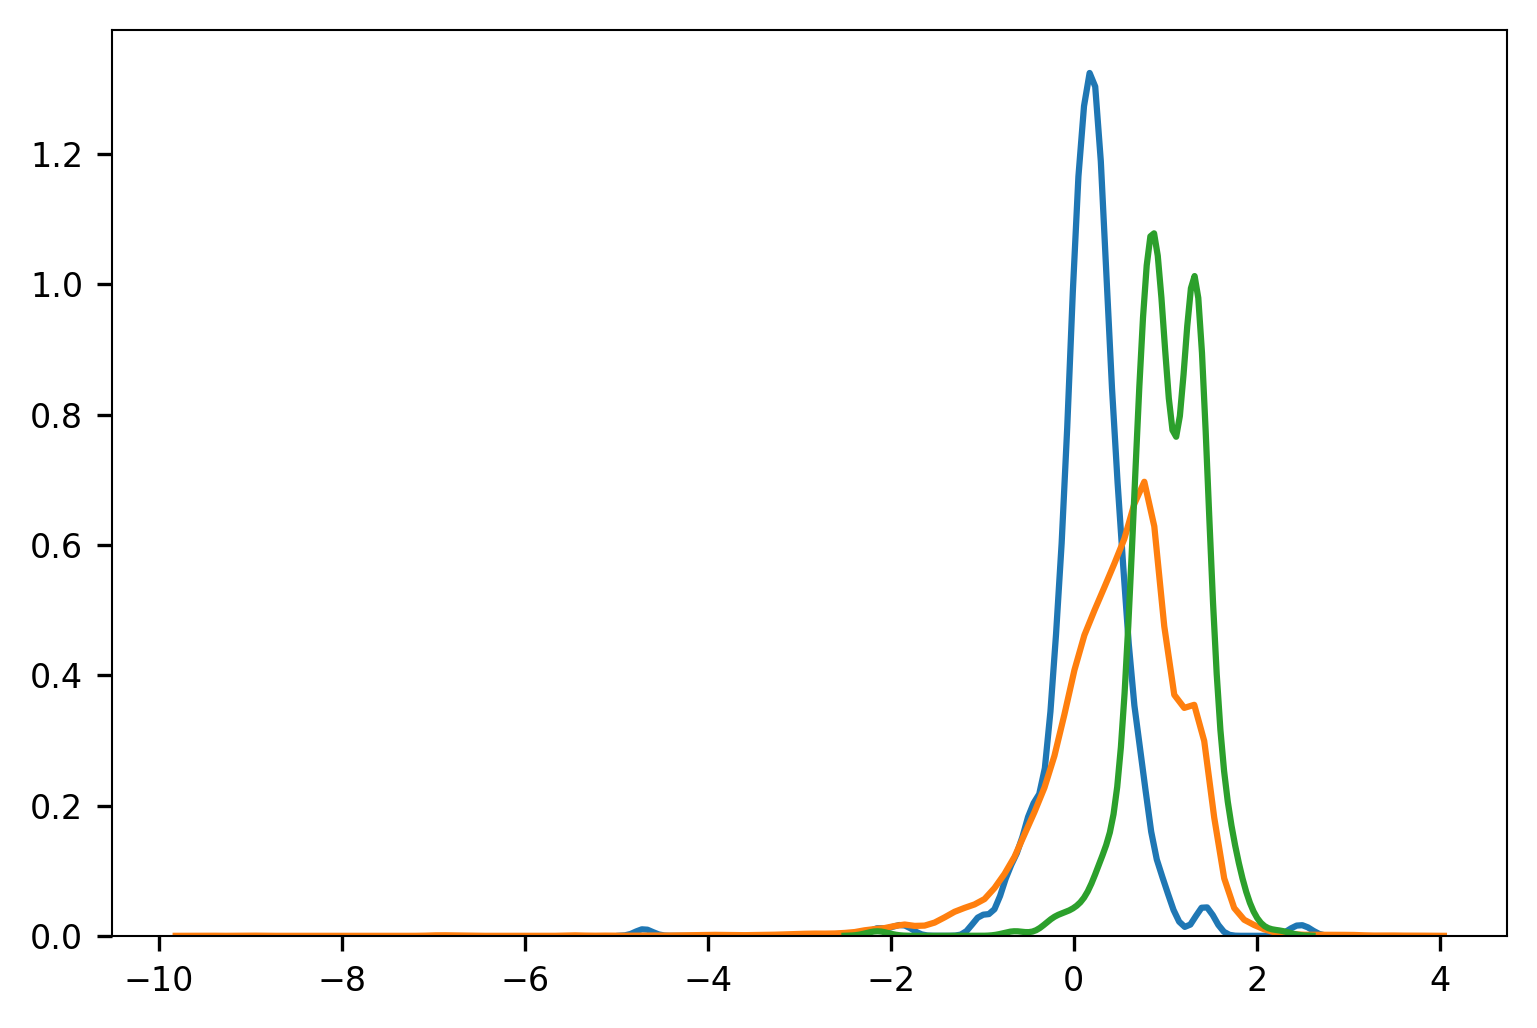

In [13]:
ax = f3_ax5

diffsel_df = pd.read_csv('../utils/diffsel_calib.csv', index_col=0)
"""# Get nucleotide variants to differentiate synonymous and nonsynon"""
variants = raw_data.select('/main/variants/scores_shared')

# Separate into nonsyn and syn lists
synon = []
nonsynon = []
synon_names = []  # This was manually confirmed to be correct later
for variant in variants.index.tolist():
    if (variant.count('(p.=)') == variant.count('(p.')) or (variant == "_wt"):
        synon.append(variants.loc[variant].values[1::2][2:])
        synon_names.append(variant)
    else:
        nonsynon.append(variants.loc[variant].values[1::2][2:])
        
# Flip scores because of negative selection
synon = -1 * np.array(synon).flatten()
nonsynon = pd.read_csv('../utils/point_muts.csv', index_col=0, header=[0,1])[2:].loc[:, ('Zero', 'score')].values

# Use seaborn to get the density plot
synon_plot = sns.distplot(diffsel_var['synon_diffsel'], hist=False)
synon_mean = np.nanmean(synon)
synon_sd = np.nanstd(synon)
print('synon mean:', synon_mean, '\n',
      'synon sd:', synon_sd, '\n',
      'synon mean - 2sd:', synon_mean - 2 * synon_sd, '\n',
      'synon mean + 2sd:', synon_mean + 2 * synon_sd)

nonsynon_plot = sns.distplot(diffsel_var['nonsynon_diffsel'], hist=False)
nonsense_plot = sns.distplot(diffsel_var['nonsense_diffsel'], hist=False)

# Get data from seaborn plots
synon_lines = synon_plot.get_lines()[0].get_data()
nonsynon_lines = nonsynon_plot.get_lines()[1].get_data()
nonsense_lines = nonsense_plot.get_lines()[2].get_data()

# Plot lines
norm_syn = synon_lines[1] / max(synon_lines[1])
norm_nonsynon = nonsynon_lines[1] / max(nonsynon_lines[1])
norm_nonsense = nonsense_lines[1] / max(nonsense_lines[1])

ax.plot(synon_lines[0], norm_syn, color='k')
ax.plot(nonsynon_lines[0], norm_nonsynon, color='k')
ax.plot(nonsense_lines[0], norm_nonsense, color='k')

# Plot line for strong client threshold
diffsel_thresh = synon_mean - 2 * synon_sd
ax.axvline(diffsel_thresh, c='k', linestyle='--')

# Plot indicators for known clients and annotate
e381r_val = diffsel_df.loc['E381R'].values[0]
t341i_val = diffsel_df.loc['T341I'].values[0]

#ax.axvline(e381r_val, c='k', linestyle='--')
#ax.axvline(t341i_val, c='k', linestyle='--')
arr_y = 0.2
dx = 0
dy = -0.2
ax.arrow(e381r_val, arr_y, dx, dy, length_includes_head=True, head_length=0.05, head_width=0.05)
ax.arrow(t341i_val, arr_y, dx, dy, length_includes_head=True, head_length=0.05, head_width=0.05)


ax.annotate('E381R', (e381r_val, 0.25), rotation=90)
ax.annotate('T341I', (t341i_val, 0.25), rotation=90)

# Plot limits
ax.set_xlim([min_val, 3])
ax.set_ylim([0, 1.5])

# Fill under the curve
ns_color = '#b3b3b3'
s_color = '#6bd581'
non_color = '#f3b2ca'
ax.fill_between(synon_lines[0], 0, norm_syn, color=s_color, alpha=0.5)
ax.fill_between(nonsense_lines[0], 0, norm_nonsense, color=non_color, alpha=0.5)
ax.fill_between(nonsynon_lines[0], 0, norm_nonsynon, color=ns_color, alpha=0.5)


# Custom legend
legend_elements = [
    #matplotlib.patches.Patch(facecolor=ns_color, alpha=0.25, label='Nonsynonymous'),
    matplotlib.patches.Patch(facecolor=s_color, alpha=0.5, label='Synonymous'),
    matplotlib.patches.Patch(facecolor=non_color, alpha=0.5, label='Nonsense'),
    matplotlib.patches.Patch(facecolor=ns_color, alpha=0.5, label='Nonsynonymous'),
                  ]
ax.legend(handles=legend_elements, loc='best')

# Set axes labels
ax.set_xlabel('Client score')
ax.set_ylabel('Density')

In [14]:
ax = f3_ax2

variants = ['F512P', '_wt', 'K298M']

# Define client scores for these variants
client_scores = diffsel_df.loc[variants, 'diffsel'].values

# Get growth rates in both conditions
grs_dmso = []
grs_rad = []
stds_dmso = []
stds_rad = []
for var in variants:
    idx = samples_in_lib.index(var)
    grs_dmso.append(dmso_rates[idx])
    grs_rad.append(rad_rates[idx])
    stds_dmso.append(dmso_std[idx])
    stds_rad.append(rad_std[idx])

# Plot points
ax.scatter(client_scores, grs_dmso, label='Basal', color='#b3b3b3')
ax.errorbar(client_scores, grs_dmso, yerr=stds_dmso, fmt='none', c='#b3b3b3')

ax.scatter(client_scores, grs_rad, label='-Hsp90', color=(src_palette[1]))
ax.errorbar(client_scores, grs_rad, yerr=stds_rad, fmt='none', color=(src_palette[1]))

# Set axis limits to match the adjacent plots
ax.set_xlim(f3_ax2.get_xlim())
ax.set_ylim(f3_ax4.get_ylim())

# Label axes and legend
ax.set_xlabel('Client score')
ax.set_ylabel('Growth rate (OD600/min)')
ax.legend(loc='lower right')
    
ax_t = ax.twiny()
ax_t.set_xlim(ax.get_xlim())
ax_t.set_xticks(client_scores)
ax_t.set_xticklabels(['F512P', 'WT', 'K298M'])

[Text(0, 1, 'F512P'), Text(0, 1, 'WT'), Text(0, 1, 'K298M')]

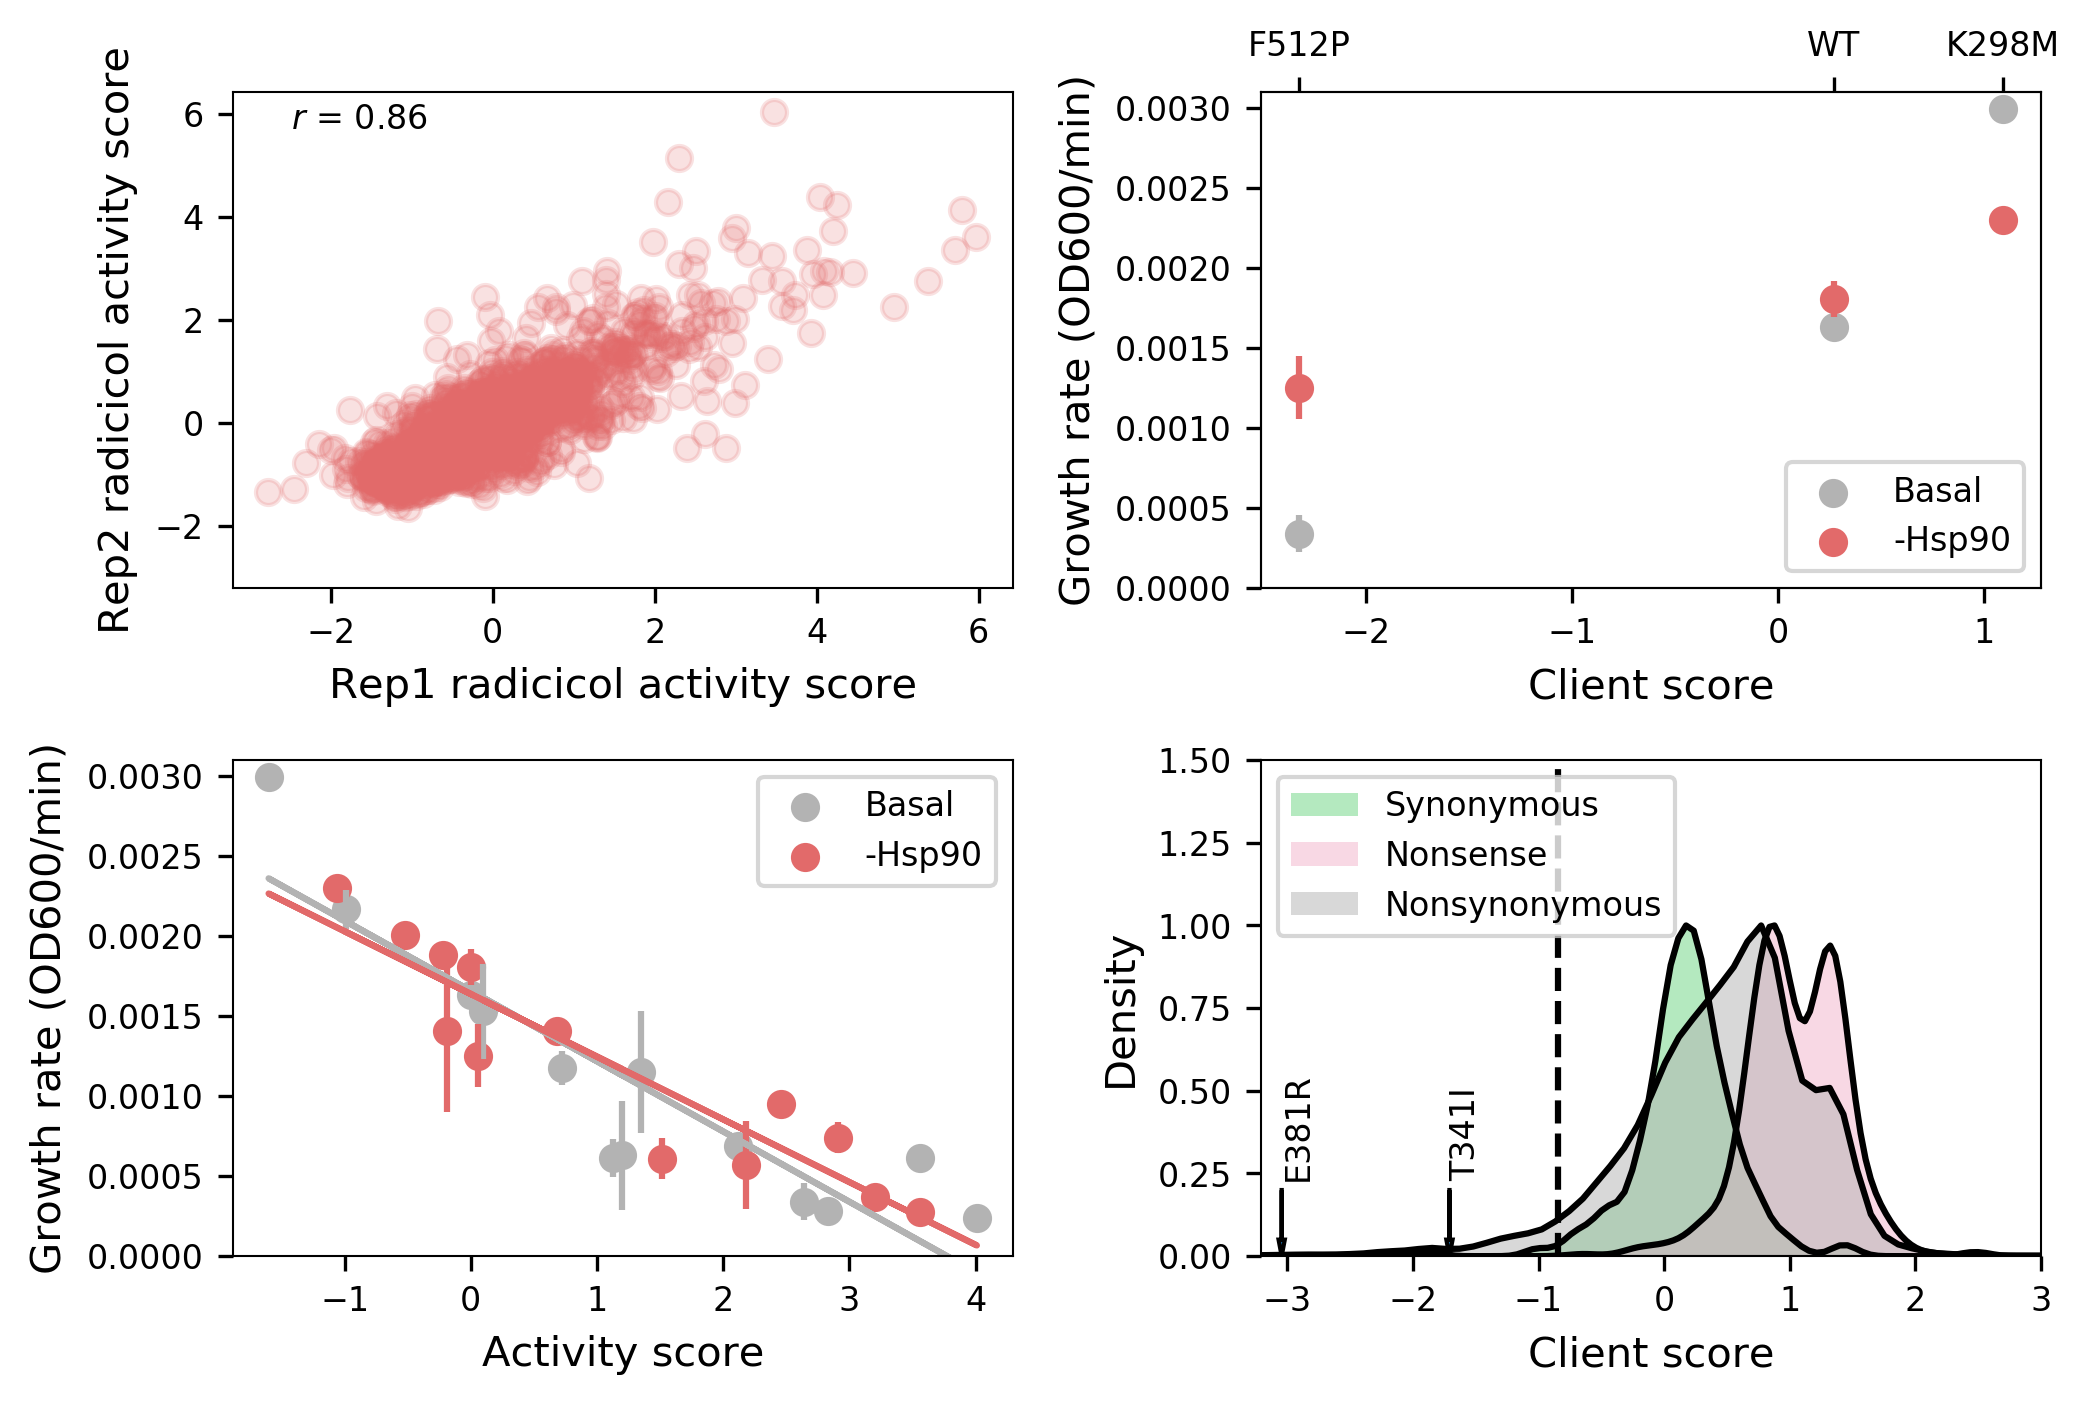

In [15]:
fig3

In [189]:
fig3.savefig('f2.png')